# Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα
## Εργασία 1: Επιβλεπόμενη Μάθηση - Ταξινόμηση
### Ομάδα 44
* Βασιλάκος Μιχαήλ <br>
Α.Μ.: 03117069
* Γαβαλάς Παντελεήμων <br>
Α.Μ.: 03117075

In [111]:
# import used modules
!pip install --upgrade imbalanced-learn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Μέρος 1: UCI dataset
Το dataset του UCI Machine Learning Repository που αντιστοιχεί στην ομάδα μας είναι το [HCC Survival Data Set](https://archive.ics.uci.edu/ml/datasets/HCC+Survival). Το συγκεκριμένο dataset περιέχει πληροφορίες σχετικά με την επιβίωση ασθενών με Ηπατοκυτταρικό καρκίνωμα (HCC) σε διάστημα ενός χρόνου από τη συλλογή των στοιχείων που δίνονται στο dataset. Δίνονται 49 features, 23 εκ των οποίων είναι κατηγορικά ενώ τα υπόλοιπα 26 είναι διατεταγμένα.

### Εισαγωγή και επισκόπηση δεδομένων

Αρχικά φορτώνουμε το dataset στο notebook και ελέγχουμε τα πρώτα στοιχεία του καθώς και τις διαστάσεις του.

In [2]:
# read dataset
df = pd.read_csv("hcc-data.txt", header=None, na_values=["?"])
print(df.head(), df.shape)

   0    1   2    3    4    5    6   ...   43    44   45    46    47    48  49
0   1  0.0   1  0.0  0.0  0.0  0.0  ...  1.0   3.5  0.5   NaN   NaN   NaN   1
1   0  NaN   0  0.0  0.0  0.0  1.0  ...  1.0   1.8  NaN   NaN   NaN   NaN   1
2   1  0.0   1  1.0  0.0  1.0  0.0  ...  5.0  13.0  0.1  28.0   6.0  16.0   1
3   1  1.0   1  0.0  0.0  0.0  0.0  ...  2.0  15.7  0.2   NaN   NaN   NaN   0
4   1  1.0   1  1.0  0.0  1.0  0.0  ...  1.0   9.0  NaN  59.0  15.0  22.0   1

[5 rows x 50 columns] (165, 50)


Το αρχείο text δεν χρειάστηκε κάποια μετατροπή για να εισαχθεί στο notebook. Βλέπουμε πως υπάρχουν 50 στήλες στο dataframe, το οποίο σημαίνει πως έχουμε 49 χαρακτηριστικά και 1 ετικέτα. Από την περιγραφή των χαρακτηριστικών στο UCI Repository βλέπουμε πως τα πρώτα 23 χαρακτηριστικά είναι μη διατεταγμένα (κατηγορικά) και είναι:
* Gender (1: Άνδρας; 0: Γυναίκα)
* Symptoms (1: Ναι; 0: Όχι)
* Alcohol (1: Ναι; 0: Όχι)
* Hepatitis B Surface Antigen (1: Ναι; 0: Όχι)
* Hepatitis B e Antigen (1: Ναι; 0: Όχι)
* Hepatitis B Core Antibody (1: Ναι; 0: Όχι)
* Hepatitis C Virus Antibody (1: Ναι; 0: Όχι)
* Cirrhosis (1: Ναι; 0: Όχι)
* Endemic Countries (1: Ναι; 0: Όχι)
* Smoking (1: Ναι; 0: Όχι)
* Diabetes (1: Ναι; 0: Όχι)
* Obesity (1: Ναι; 0: Όχι)
* Hemochromatosis (1: Ναι; 0: Όχι)
* Arterial Hypertension (1: Ναι; 0: Όχι)
* Chronic Renal Insufficiency (1: Ναι; 0: Όχι)
* Human Immunodeficiency Virus (1: Ναι; 0: Όχι)
* Nonalcoholic Steatohepatitis (1: Ναι; 0: Όχι)
* Esophageal Varices (1: Ναι; 0: Όχι)
* Splenomegaly (1: Ναι; 0: Όχι)
* Portal Hypertension (1: Ναι; 0: Όχι)
* Portal Vein Thrombosis (1: Ναι; 0: Όχι)
* Liver Metastasis (1: Ναι; 0: Όχι)
* Radiological Hallmark  (1: Ναι; 0: Όχι)

Το dataset δεν περιέχει επικεφαλίδες ούτε αρίθμηση σειρών. Οι ετικέτες των κλάσεων είναι στην 50η στήλη και λαμβάνουν τιμές 1 και 0, όπου το 1 εκφράζει την επιβίωση του ασθενή στον 1 χρόνο ενώ το 0 το αντίθετο.

In [3]:
# find missing values
print("Total missing values:", df.isnull().sum(axis=1).sum())
# find samples with missing values
missing_samples = df.isnull().any(axis=1).sum()
print("Number of samples with missing values: {} which represents {:.2f}% \
of total samples".format(missing_samples, missing_samples/df.shape[0]*100))
# find features with missing values
missing_cols = df.isnull().sum(axis=0)
missing_cols_percent = ["{:.1f}%".format(x/df.shape[0]*100) for x in missing_cols]
print("Percentage of samples with missing features:")
for i in range(len(missing_cols_percent)-1):
  print("Feature {}: {}".format(i, missing_cols_percent[i]))

Total missing values: 826
Number of samples with missing values: 157 which represents 95.15% of total samples
Percentage of samples with missing features:
Feature 0: 0.0%
Feature 1: 10.9%
Feature 2: 0.0%
Feature 3: 10.3%
Feature 4: 23.6%
Feature 5: 14.5%
Feature 6: 5.5%
Feature 7: 0.0%
Feature 8: 23.6%
Feature 9: 24.8%
Feature 10: 1.8%
Feature 11: 6.1%
Feature 12: 13.9%
Feature 13: 1.8%
Feature 14: 1.2%
Feature 15: 8.5%
Feature 16: 13.3%
Feature 17: 31.5%
Feature 18: 9.1%
Feature 19: 6.7%
Feature 20: 1.8%
Feature 21: 2.4%
Feature 22: 1.2%
Feature 23: 0.0%
Feature 24: 29.1%
Feature 25: 32.1%
Feature 26: 0.0%
Feature 27: 0.6%
Feature 28: 1.2%
Feature 29: 2.4%
Feature 30: 4.8%
Feature 31: 1.8%
Feature 32: 1.8%
Feature 33: 1.8%
Feature 34: 1.8%
Feature 35: 3.6%
Feature 36: 3.0%
Feature 37: 2.4%
Feature 38: 1.8%
Feature 39: 1.8%
Feature 40: 1.8%
Feature 41: 6.7%
Feature 42: 4.2%
Feature 43: 1.2%
Feature 44: 12.1%
Feature 45: 26.7%
Feature 46: 47.9%
Feature 47: 48.5%
Feature 48: 48.5%


Παρατηρούμε πως μας λείπουν 826 τιμές συνολικά. Δεδομένου ότι έχουμε 49 χαρακτηριστικά και 165 δείγματα μας λείπουν $\frac{826}{49*165}*100\% = 10.2\%$ των τιμών του dataset. Επιπλέον, είδαμε πως πάνω από το 95% των δειγμάτων έχουν τουλάχιστον μία τιμή που απουσιάζει, οπότε δεν είναι δυνατή η αφαίρεση των δειγμάτων των οποίων οι τιμές απουσιάζουν. Επίσης είδαμε πως 7 από τα 49 χαρακτηριστικά απουσιάζουν για πάνω από το 25% των δειγμάτων, ενώ 3 εξ αυτών απουσιάζουν για περίπου τα μισά δείγματα.

In [4]:
# count instances of each class
class1 = df.iloc[:,49].sum()
class0 = df.shape[0] - class1
print("Class 0 has {} samples which represents {:.1f}% of all samples".format
      (class0, class0/df.shape[0]*100))
print("Class 1 has {} samples which represents {:.1f}% of all samples".format
      (class1, class1/df.shape[0]*100))

Class 0 has 63 samples which represents 38.2% of all samples
Class 1 has 102 samples which represents 61.8% of all samples


Παρατηρούμε πως η κλάση 1 (ο ασθενής ζει) αντιπροσωπεύει το 61.8% των δειγμάτων του dataset, έναντι του 38.2% που αντιστοιχεί στην κλάση 0 (ο ασθενής πεθαίνει). Αυτό σημαίνει πως το dataset δεν είναι ισορροπημένο και συνεπώς απαιτείται ειδικός χειρισμός για την αποτελεσματικότερη χρήση του.

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,67,137.0,15.0,0,1.0,1.0,1.53,95.0,13.7,106.6,4.9,99.0,3.4,2.1,34.0,41.0,183.0,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,62,0.0,NaN,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
2,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,78,50.0,50.0,2,1.0,2.0,0.96,5.8,8.9,79.8,8.4,472.0,3.3,0.4,58.0,68.0,202.0,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,77,40.0,30.0,0,1.0,1.0,0.95,2440.0,13.4,97.1,9.0,279.0,3.7,0.4,16.0,64.0,94.0,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
4,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,76,100.0,30.0,0,1.0,1.0,0.94,49.0,14.3,95.1,6.4,199.0,4.1,0.7,147.0,306.0,173.0,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1


### Προετοιμασία δεδομένων

Χωρίζουμε το dataset σε δύο μέρη ώστε να δημιουργήσουμε τα train και test sets με το test set να αποτελεί το 30% των δειγμάτων.

In [6]:
# differentiate labels from features
X_df = df.iloc[:,:49].copy()
y_df = df.iloc[:,49].copy()

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=.3)

Επειδή όπως δείξαμε παραπάνω στα features 46, 47 και 48 λείπουν οι τιμές για περίπου τα μισά δείγματα, η συμπλήρωσή τους δεν αποτελεί καλή πρακτική και για τον λόγο αυτό τα αφαιρούμε από τα δεδομένα μας.

In [7]:
X_train.drop([46, 47, 48], axis=1, inplace=True)
X_test.drop([46, 47, 48], axis=1, inplace=True)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
102,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,64,70.0,NaN,2,1.0,2.0,1.55,5.7,13.9,99.7,5200.0,124000.0,2.1,0.8,37.0,75.0,203.0,110.0,5.0,0.56,3.0,2.4,NaN
60,1,1.0,0,1.0,0.0,1.0,0.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,76,0.0,50.0,1,1.0,3.0,1.28,608.0,12.6,100.0,5.4,129.0,4.0,1.7,107.0,99.0,125.0,100.0,7.5,0.90,5.0,3.5,0.5
31,1,0.0,1,0.0,NaN,0.0,0.0,1,NaN,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,62,120.0,NaN,0,1.0,1.0,1.44,1237.0,12.2,94.0,6200.0,93000.0,4.2,1.0,35.0,85.0,191.0,129.0,58.0,1.06,5.0,7.0,NaN
37,1,1.0,1,0.0,0.0,0.0,0.0,1,NaN,1.0,1.0,0.0,NaN,1.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,84,200.0,30.0,1,1.0,2.0,1.24,633.0,13.0,96.5,7200.0,143000.0,2.3,1.1,40.0,58.0,322.0,209.0,6.7,1.40,5.0,4.9,0.2
33,1,1.0,1,0.0,NaN,0.0,0.0,1,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,77,NaN,NaN,0,1.0,1.0,1.24,266.0,13.7,97.7,13000.0,170000.0,4.2,0.5,68.0,85.0,232.0,227.0,16.8,1.72,1.0,5.9,NaN


Εφόσον τα features 0-22 είναι categorical επιλέγουμε να τα συμπληρώσουμε με τις πιο συχνές τιμές για κάθε feature στο training set, ενώ την ίδια τιμή συμπληρώνουμε και στο test set, αφού όποια αλλαγή κάνουμε στα δεδομένα μας πρέπει να γίνεται με βάση την επεξεργασία μόνο των δεδομένων στο training set.

Για τα υπόλοιπα features θα αντικαταστήσουμε τον μέσο όρο των τιμών στο training set.

In [8]:
imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")

In [9]:
X_train.iloc[:,:23] = imp_freq.fit_transform(X_train.iloc[:,:23])
X_train.iloc[:,23:] = imp_mean.fit_transform(X_train.iloc[:,23:])

Επιβεβαιώνουμε πως δεν υπάρχουν πλέον κενά πεδία στο training set.

In [10]:
X_train.isnull().any().any()

False

Τα κατηγορικά δεδομένα δεν χρειάζεται να τα τροποποιήσουμε με κάποια τεχνική (π.χ. one-hot encoding) διότι ήδη βρίσκονται σε μορφή Ναι-Όχι (με το 1 να αναπαριστά το "Ναι" και το 0 το "Όχι").

Επαναλαμβάνουμε με τα δεδομένα του test set χρησιμοποιόντας πληροφορία αποκλειστικά από τα δεδομένα του training set ώστε να μην έχουμε απουσιάζουσες τιμές.

In [11]:
X_test.iloc[:,:23] = imp_freq.transform(X_test.iloc[:,:23])
X_test.iloc[:,23:] = imp_mean.transform(X_test.iloc[:,23:])

Ελέγχουμε ξανά για κενά πεδία.

In [12]:
X_test.isnull().any().any()

False

### Ταξινόμηση
Οι ταξινομητές που θα μελετηθούν είναι οι:
* dummy
* Gaussian Naive Bayes (GNB)
* KNearestNeighbors (kNN)
* Logistic Regression (LR)

Οι μετρικές αξιολόγησης που θα χρησιμοποιηθούν είναι οι:
* Ορθότητα (accuracy)
* F1-score

Για όλα τα πειράματα θα χρησιμοποιήσουμε 10-fold cross-validation.

#### Επίδοση out-of-the-box
Για να έχουμε μία βάση σύγκρισης θα εκτελέσουμε αρχικά το πείραμα αφήνοντας τις υπερπαραμέτρους των ταξινομητών στις default τιμές τους.

Αρχικά ορίζουμε τους ταξινομητές.

In [13]:
dummy_stratified = DummyClassifier(strategy="stratified")
dummy_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_uniform = DummyClassifier(strategy="uniform")
dummy_const_0 = DummyClassifier(strategy="constant", constant=0)
dummy_const_1 = DummyClassifier(strategy="constant", constant=1)

gnb = GaussianNB()
knn = KNeighborsClassifier()
lr = LogisticRegression()

Στη συνέχεια εκπαιδεύουμε τους ταξινομητές και συγκρίνουμε τα αποτελέσματά τους.

In [14]:
ootb_accuracy = {}

dummy_stratified.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (stratified)"] = accuracy_score(y_test, dummy_stratified.predict(X_test))
dummy_most_frequent.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (most frequent)"] = accuracy_score(y_test, dummy_most_frequent.predict(X_test))
dummy_uniform.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (uniform)"] = accuracy_score(y_test, dummy_uniform.predict(X_test))
dummy_const_0.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (constant 0)"] = accuracy_score(y_test, dummy_const_0.predict(X_test))
dummy_const_1.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (constant 1)"] = accuracy_score(y_test, dummy_const_1.predict(X_test))

gnb.fit(X_train, y_train)
ootb_accuracy["Gaussian Naive-Bayes"] = accuracy_score(y_test, gnb.predict(X_test))
knn.fit(X_train, y_train)
ootb_accuracy["K Nearest Neighbors"] = accuracy_score(y_test, knn.predict(X_test))
lr.fit(X_train, y_train)
ootb_accuracy["Logistic Regression"] = accuracy_score(y_test, lr.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Παρατηρούμε πως ο ταξινομητής logistic regression δεν συγκλίνει κατά την εκπαίδευσή του στην out-of-the-box έκδοσή του.

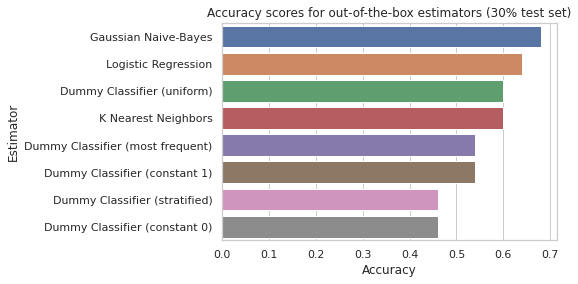

In [15]:
sorted_accuracy = [(k, ootb_accuracy[k]) for k in sorted(ootb_accuracy, key=ootb_accuracy.get, reverse=True)]
acc_df = pd.DataFrame.from_dict(sorted_accuracy)

sns.set_theme(style="whitegrid")
sns.barplot(y=acc_df.iloc[:,0], x=acc_df.iloc[:,1], data=acc_df)
plt.xlabel("Accuracy")
plt.ylabel("Estimator")
plt.title("Accuracy scores for out-of-the-box estimators (30% test set)")
plt.show()

In [16]:
ootb_f1 = {}

dummy_stratified.fit(X_train, y_train)
ootb_f1["Dummy Classifier (stratified)"] = f1_score(y_test, dummy_stratified.predict(X_test))
dummy_most_frequent.fit(X_train, y_train)
ootb_f1["Dummy Classifier (most frequent)"] = f1_score(y_test, dummy_most_frequent.predict(X_test))
dummy_uniform.fit(X_train, y_train)
ootb_f1["Dummy Classifier (uniform)"] = f1_score(y_test, dummy_uniform.predict(X_test))
dummy_const_0.fit(X_train, y_train)
ootb_f1["Dummy Classifier (constant 0)"] = f1_score(y_test, dummy_const_0.predict(X_test))
dummy_const_1.fit(X_train, y_train)
ootb_f1["Dummy Classifier (constant 1)"] = f1_score(y_test, dummy_const_1.predict(X_test))

gnb.fit(X_train, y_train)
ootb_f1["Gaussian Naive-Bayes"] = f1_score(y_test, gnb.predict(X_test))
knn.fit(X_train, y_train)
ootb_f1["K Nearest Neighbors"] = f1_score(y_test, knn.predict(X_test))
lr.fit(X_train, y_train)
ootb_f1["Logistic Regression"] = f1_score(y_test, lr.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Ξανά, ο logistic regression δεν καταφέρει να συγκλίνει στην εκπαίδευσή του.

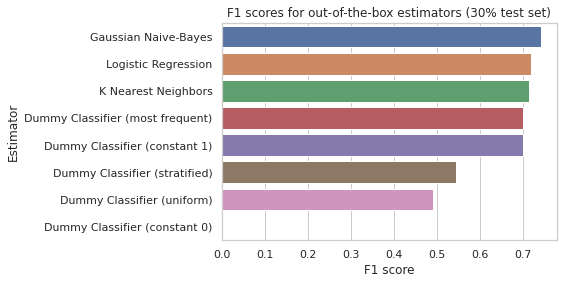

In [17]:
sorted_f1 = [(k, ootb_f1[k]) for k in sorted(ootb_f1, key=ootb_f1.get, reverse=True)]
f1_df = pd.DataFrame.from_dict(sorted_f1)

sns.set_theme(style="whitegrid")
sns.barplot(y=f1_df.iloc[:,0], x=f1_df.iloc[:,1], data=f1_df)
plt.xlabel("F1 score")
plt.ylabel("Estimator")
plt.title("F1 scores for out-of-the-box estimators (30% test set)")
plt.show()

In [18]:
print(ootb_accuracy)
print(ootb_f1)

{'Dummy Classifier (stratified)': 0.46, 'Dummy Classifier (most frequent)': 0.54, 'Dummy Classifier (uniform)': 0.6, 'Dummy Classifier (constant 0)': 0.46, 'Dummy Classifier (constant 1)': 0.54, 'Gaussian Naive-Bayes': 0.68, 'K Nearest Neighbors': 0.6, 'Logistic Regression': 0.64}
{'Dummy Classifier (stratified)': 0.5454545454545454, 'Dummy Classifier (most frequent)': 0.7012987012987013, 'Dummy Classifier (uniform)': 0.49056603773584906, 'Dummy Classifier (constant 0)': 0.0, 'Dummy Classifier (constant 1)': 0.7012987012987013, 'Gaussian Naive-Bayes': 0.7419354838709677, 'K Nearest Neighbors': 0.7142857142857142, 'Logistic Regression': 0.7187499999999999}


|       Classifier      | Accuracy | F1 score |
|:---------------------:|:--------:|:--------:|
| Dummy (most frequent) |   0.54   |   0.70   |
|   Dummy (constant 1)  |   0.54   |   0.70   |
|   Dummy (stratified)  |   0.46   |   0.55   |
|    Dummy (uniform)    |   0.60   |   0.49   |
|   Dummy (constant 0)  |   0.46   |   0.00   |
|  Logistic Regression  |   0.64   |   0.74   |
|  Gaussian Naive-Bayes |   0.68   |   0.74   |
|  K Nearest Neighbors  |   0.60   |   0.71   |

Παρατηρούμε πως οι ταξινομητές δεν έχουν ιδιαίτερα καλή επίδοση, καθώς οι dummy ταξινομητές uniform και most frequent έχουν αρκετά υψηλές επιδόσεις, συγκρίσιμες με αυτές των ταξινομητών που μελετάμε. Οι καλές επιδόσεις των dummy ταξινομητών οφείλονται στο έντονο class imbalance που εμφανίζεται στο dataset.

Από τους ταξινομητές, εξαιρώντας τους dummy, τις καλύτερες επιδόσεις και στις δύο μετρικές έχει ο Gaussian Naive-Bayes, ενώ αυτός με τις χειρότερες επιδόσεις είναι ο K Nearest Neighbors. 

#### Βελτιστοποίηση

Σκοπός αυτής της ενότητας είναι η βελτίωση της επίδοσης των ταξινομητών με χρήση των διαδικασιών προεπεξεργασίας, ορισμού pipelines και εύρεσης βέλτιστων υπερπαραμέτρων με grid search με cross validation.

Στο στάδιο της προεπεξεργασίας έχουμε να αντιμετωπίσουμε τα προβλήματα της υψηλής διαστατικότητας, των outliers και του class imbalance. 
* Ξεκινώντας από το πρώτο, μπορούμε να μειώσουμε τις διαστάσεις των δεδομένων μας αρχικά ορίζοντας κάποιο threshold του variance κάθε χαρακτηριστικού, καθώς χαρακτηριστικά με μικρό variance συνήθως δεν συμβάλλουν σημαντικά στην ταξινόμηση. Επιπλέον, με εξαγωγή κύριων συνιστωσών (PCA) μπορούμε να μειώσουμε ακόμα περισσότερο το πλήθος των χαρακτηριστικών.
* Βελτίωση των επιδόσεων των συστημάτων ταξινόμησης μπορούμε να επιτύχουμε και μέσω της κανονικοποίησης των τιμών των χαρακτηριστικών.
* Τέλος, το πρόβλημα του class imbalance μπορεί να βελτιωθεί μέσω του oversampling (αποφεύγουμε το undersampling λόγω των λίγων δειγμάτων του dataset).

Στο επόμενο στάδιο ορίζουμε pipelines από τα οποία περνάνε τα δεδομένα για να εισέλθουν στους ταξινομητές και στα οποία εκτελούμε τις εργασίες που αναφέραμε παραπάνω στο στάδιο προεπεξεργασίας.

Τέλος, με χρήση του grid search cross validation επιλέγουμε τις καλύτερες τιμές για τις υπερπαραμέτρους του pipeline. 

##### F1 score
Αρχικά θα αξιολογήσουμε την επίδοση των μοντέλων με τη μετρική f1.

Αρχικά, εκτελούμε τη διαδικασία βελτιστοποίησης στον ταξινομητή kNN, όπου και ελέγχουμε ένα πλήθος τιμών για τις παραμέτρους threshold του VarianceThreshold(), n_neighbors του KNeighborsClassifier() και n_components του PCA().<br>
Επιπλέον, δοκιμάσαμε να κάνουμε χρήση των μετασχηματιστών MinMaxScaler() και StandardScaler() και βρήκαμε πως με τον πρώτο επιτυγχάνουμε καλύτερα αποτελέσματα στο training set.<br>
Τέλος, δοκιμάσαμε να αφαιρέσουμε βήματα από το pipeline, όμως η επίδοση του ταξινομητή στο training set μειωνόταν.

In [91]:
vthreshold = [0, 0.01, 0.1, 1, 10]
k = [1, 5, 10, 20, 25, 30, 35, 50]
n_components = [2, 4, 5, 7, 10]

scaler_knn = MinMaxScaler()
selector_knn = VarianceThreshold()
ros_knn = RandomOverSampler()
pca_knn = PCA()
knn = KNeighborsClassifier()

pipe_knn = Pipeline(
    steps=[
           ('selector', selector_knn),
           ('scaler', scaler_knn),
           ('sampler', ros_knn),
           ('pca', pca_knn),
           ('knn', knn)
           ], 
    memory='tmp')
estimator_knn_f1 = GridSearchCV(pipe_knn, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  knn__n_neighbors=k,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='f1', 
                             n_jobs=-1)

start_time = time.time()
estimator_knn_f1.fit(X_train, y_train)
preds_knn = estimator_knn_f1.predict(X_test)
print("Συνολικός χρόνος fit και predict για kNN με μετρική f1 score: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_knn_f1.best_params_)
print("Το καλύτερο f1 score του ταξινομητή ήταν {:.3f} στο training set".format(estimator_knn_f1.best_score_))

Συνολικός χρόνος fit και predict για kNN με μετρική f1 score: 31.12 seconds
Βέλτιστες παράμετροι: {'knn__n_neighbors': 50, 'pca__n_components': 7, 'selector__threshold': 1}
Το καλύτερο f1 score του ταξινομητή ήταν 0.795 στο training set


Επαναλαμβάνουμε την ίδια διαδικασία για τον ταξινομητή GNB με τη διαφορά πως αντί να μεταβάλλουμε την τιμή n_neighbors αλλάζουμε την τιμή της υπερπαραμέτρου var_smoothing του GaussianNB().<br>
Όμοια με πριν δοκιμάσαμε τόσο τον MinMaxScaler() όσο και τον StandardScaler() και με τον δεύτερο πετύχαμε καλύτερα αποτελέσματα, ενώ επίσης δοκιμάσαμε να αφαιρέσουμε βήματα από το pipeline χωρίς να βελτιώσουμε την επίδοση του ταξινομητή στο training set.

In [92]:
vthreshold = [0, 0.01, 0.1, 1, 10]
var_smoothing = [0, 1e-13, 1e-11, 1e-9, 1e-8]
n_components = [2, 4, 5, 7, 10]

scaler_gnb = StandardScaler()
selector_gnb = VarianceThreshold()
ros_gnb = RandomOverSampler()
pca_gnb = PCA()
gnb = GaussianNB()

pipe_gnb = Pipeline(
    steps=[
           ('selector', selector_gnb),
           ('scaler', scaler_gnb),
           ('sampler', ros_gnb),
           ('pca', pca_gnb),
           ('gnb', gnb)
           ], 
    memory='tmp')
estimator_gnb_f1 = GridSearchCV(pipe_gnb, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  gnb__var_smoothing=var_smoothing,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='f1', 
                             n_jobs=-1)

start_time = time.time()
estimator_gnb_f1.fit(X_train, y_train)
preds_gnb = estimator_gnb_f1.predict(X_test)
print("Συνολικός χρόνος fit και predict για GNB με μετρική f1 score: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_gnb_f1.best_params_)
print("Το καλύτερο f1 score του ταξινομητή ήταν {:.3f} στο training set".format(estimator_gnb_f1.best_score_))

Συνολικός χρόνος fit και predict για GNB με μετρική f1 score: 17.78 seconds
Βέλτιστες παράμετροι: {'gnb__var_smoothing': 0, 'pca__n_components': 2, 'selector__threshold': 0.01}
Το καλύτερο f1 score του ταξινομητή ήταν 0.792 στο training set


Τέλος, επαναλαμβάνουμε για τον LR ψάχνοντας για τις καλύτερες τιμές στις υπερπαραμέτρους pen, tol, C, fit_intercept και max_iter του LogisticRegressor().<br>
Ο scaler με την καλύτερη επίδοση εδώ είναι ο StandardScaler(), ενώ πάλι δεν είδαμε βελτίωση με την αφαίρεση βημάτων από το pipeline.

In [93]:
vthreshold = [0, 0.1, 1]
n_components = [2, 5, 7, 10]
pen = ['l1', 'l2']
tol = [1e-8, 1e-6, 1e-4, 1e-3]
C = [0.5, 1.0, 1.5, 2.0, 2.5]
fit_intercept = [True, False]
max_iter = [50, 100, 200]

scaler_lr = StandardScaler()
selector_lr = VarianceThreshold()
ros_lr = RandomOverSampler()
pca_lr = PCA()
lr = LogisticRegression()

pipe_lr = Pipeline(
    steps=[
           ('selector', selector_lr),
           ('scaler', scaler_lr),
           ('sampler', ros_lr),
           ('pca', pca_lr),
           ('lr', lr)
           ], 
    memory='tmp')
estimator_lr_f1 = GridSearchCV(pipe_lr, 
                             dict(
                                  selector__threshold=vthreshold,
                                  pca__n_components=n_components,
                                  lr__penalty=pen,
                                  lr__tol=tol,
                                  lr__C=C,
                                  lr__fit_intercept=fit_intercept,
                                  lr__max_iter=max_iter,
                                  lr__solver=['liblinear']
                                  ), 
                             cv=10, 
                             scoring='f1', 
                             n_jobs=-1)

start_time = time.time()
estimator_lr_f1.fit(X_train, y_train)
preds_lr = estimator_lr_f1.predict(X_test)
print("Συνολικός χρόνος fit και predict για LR με μετρική f1 score: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_lr_f1.best_params_)
print("Το καλύτερο f1 score του ταξινομητή ήταν {:.3f} στο training set".format(estimator_lr_f1.best_score_))

Συνολικός χρόνος fit και predict για LR με μετρική f1 score: 428.07 seconds
Βέλτιστες παράμετροι: {'lr__C': 0.5, 'lr__fit_intercept': True, 'lr__max_iter': 50, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'lr__tol': 1e-08, 'pca__n_components': 10, 'selector__threshold': 0.1}
Το καλύτερο f1 score του ταξινομητή ήταν 0.770 στο training set


Εκπαιδεύουμε για κάθε ταξινομητή το μοντέλο με τις καλύτερες επιδόσεις σε ολόκληρο το training set και υπολογίζουμε το f1 score του στο test set ώστε να το συγκρίνουμε με το αντίστοιχο out-of-the-box μοντέλο. 

In [114]:
knn_best_f1 = estimator_knn_f1.best_estimator_
gnb_best_f1 = estimator_gnb_f1.best_estimator_
lr_best_f1 = estimator_lr_f1.best_estimator_

start_train_time_knn = time.time()
knn_best_f1.fit(X_train, y_train)
train_time_knn = time.time() - start_train_time_knn
start_test_time_knn = time.time()
knn_f1 = f1_score(y_test, knn_best_f1.predict(X_test))
test_time_knn = time.time() - start_test_time_knn

start_train_time_gnb = time.time()
gnb_best_f1.fit(X_train, y_train)
train_time_gnb = time.time() - start_train_time_gnb
start_test_time_gnb = time.time()
gnb_f1 = f1_score(y_test, gnb_best_f1.predict(X_test))
test_time_gnb = time.time() - start_test_time_gnb

start_train_time_lr = time.time()
lr_best_f1.fit(X_train, y_train)
train_time_lr = time.time() - start_train_time_lr
start_test_time_lr = time.time()
lr_f1 = f1_score(y_test, lr_best_f1.predict(X_test))
test_time_lr = time.time() - start_test_time_lr

optimized_f1 = {}
optimized_f1["K Nearest Neighbors"] = knn_f1
optimized_f1["Gaussian Naive-Bayes"] = gnb_f1
optimized_f1["Logistic Regression"] = lr_f1

baseline_f1 = {}
baseline_f1["K Nearest Neighbors"] = ootb_f1["K Nearest Neighbors"]
baseline_f1["Gaussian Naive-Bayes"] = ootb_f1["Gaussian Naive-Bayes"]
baseline_f1["Logistic Regression"] = ootb_f1["Logistic Regression"]

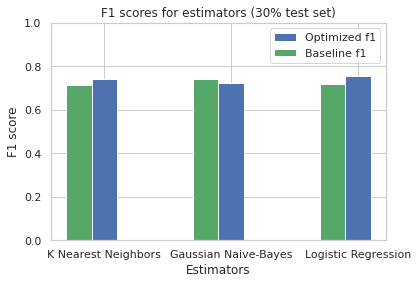

In [95]:
xax = np.arange(len(optimized_f1))
ax = plt.subplot(111)
ax.bar(xax, optimized_f1.values(), width=0.2, color='b', align='center')
ax.bar(xax-0.2, baseline_f1.values(), width=0.2, color='g', align='center')
ax.legend(('Optimized f1','Baseline f1'))
plt.xticks(xax, optimized_f1.keys())
plt.ylabel("F1 score")
plt.xlabel("Estimators")
plt.title("F1 scores for estimators (30% test set)")
ax.set_ylim([0, 1])
plt.show()

In [96]:
print("Αρχικές επιδόσεις:", baseline_f1)
print("Επιδόσεις βελτιστοποιημένων ταξινομητών:", optimized_f1)
print("kNN train time {:.2f} ms".format(train_time_knn*1000))
print("kNN test time {:.2f} ms".format(test_time_knn*1000))
print("GNB train time {:.2f} ms".format(train_time_gnb*1000))
print("GNB test time {:.2f} ms".format(test_time_gnb*1000))
print("LR train time {:.2f} ms".format(train_time_lr*1000))
print("LR test time {:.2f} ms".format(test_time_lr*1000))

Αρχικές επιδόσεις: {'K Nearest Neighbors': 0.7142857142857142, 'Gaussian Naive-Bayes': 0.7419354838709677, 'Logistic Regression': 0.7187499999999999}
Επιδόσεις βελτιστοποιημένων ταξινομητών: {'K Nearest Neighbors': 0.7428571428571429, 'Gaussian Naive-Bayes': 0.7213114754098361, 'Logistic Regression': 0.7547169811320754}
kNN train time 24.52 ms
kNN test time 10.96 ms
GNB train time 15.63 ms
GNB test time 4.10 ms
LR train time 22.07 ms
LR test time 5.22 ms


| Classifier           | Best F1 score (training set) | F1 score (baseline) | F1 score (optimized) | Optimization time (sec) | Train time (ms) | Test time (ms) |
|----------------------|------------------------------|---------------------|----------------------|-------------------------|-----------------|----------------|
| K Nearest Neighbors  | 79.5%                        | 71.4%                 | 74.3%                | 31.12                   | 24.52           | 10.96          |
| Gaussian Naive-Bayes | 79.2%                        | 74.2%               | 72.1%                | 17.78                   | 15.63           | 4.10           |
| Logistic Regression  | 77.0%                        | 71.9%               | 75.5%                | 428.07                  | 22.07           | 5.22           |

Παρατηρούμε πως στους ταξινομητές kNN και LR έχουμε μία μικρή αύξηση της μετρικής f1 έναντι των out-of-the-box εκδόσεών τους, ενώ ο GNB χειροτερεύει την απόδοσή του. Ο χρόνος που καταλαμβάνει η βελτιστοποίηση στον LR είναι εξαιρετικά μεγαλύτερος από τους άλλους δύο ταξινομητές, τόσο λόγω του τρόπου που αυτός λειτουργεί, όσο και λόγω του μεγαλύτερου πλήθους παραμέτρων που λαμβάνει. Ο χρόνος train και test είναι αρκετά κοντά για όλους τους ταξινομητές, το οποίο οφείλεται στο μικρό μέγεθος του dataset. Η βελτίωση στο f1 score δεν δικαιολογεί τον χρόνο του optimization, αφού ο GNB πετυχαίνει 74.2% πριν το optimization, με την καλύτερη τιμή μετά από αυτό να την πετυχαίνουμε με τον LR με 75.5% με optimization που διαρκεί 428 sec. Τέλος, με βάση τη μετρική f1 δεν έχουμε ξεκάθαρο νικητή, αφού τα αποτελέσματά τους βρίσκονται αρκετά κοντά μετά την βελτιστοποίηση.

##### Accuracy
Επαναλαμβάνουμε την ίδια ακριβώς διαδικασία χρησιμοποιώντας τη μετρική accuracy για την αξιολόγηση του μοντέλου.

In [103]:
vthreshold = [0, 0.01, 0.1, 1, 10]
k = [1, 5, 10, 20, 25, 30, 35, 50]
n_components = [2, 4, 5, 7, 10]

scaler_knn = MinMaxScaler()
selector_knn = VarianceThreshold()
ros_knn = RandomOverSampler()
pca_knn = PCA()
knn = KNeighborsClassifier()

pipe_knn = Pipeline(
    steps=[
           ('selector', selector_knn),
           ('scaler', scaler_knn),
           ('sampler', ros_knn),
           ('pca', pca_knn),
           ('knn', knn)
           ], 
    memory='tmp')
estimator_knn_acc = GridSearchCV(pipe_knn, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  knn__n_neighbors=k,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='accuracy', 
                             n_jobs=-1)

start_time = time.time()
estimator_knn_acc.fit(X_train, y_train)
preds_knn = estimator_knn_acc.predict(X_test)

print("Συνολικός χρόνος fit και predict για kNN με μετρική accuracy: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_knn_acc.best_params_)
print("Το καλύτερο accuracy του ταξινομητή ήταν {:.3f} στο training set".format(estimator_knn_acc.best_score_))

Συνολικός χρόνος fit και predict για kNN με μετρική accuracy: 29.00 seconds
Βέλτιστες παράμετροι: {'knn__n_neighbors': 35, 'pca__n_components': 4, 'selector__threshold': 1}
Το καλύτερο accuracy του ταξινομητή ήταν 0.722 στο training set


In [104]:
vthreshold = [0, 0.01, 0.1, 1, 10]
var_smoothing = [0, 1e-13, 1e-11, 1e-9, 1e-8]
n_components = [2, 4, 5, 7, 10]

scaler_gnb = StandardScaler()
selector_gnb = VarianceThreshold()
ros_gnb = RandomOverSampler()
pca_gnb = PCA()
gnb = GaussianNB()

pipe_gnb = Pipeline(
    steps=[
           ('selector', selector_gnb),
           ('scaler', scaler_gnb),
           ('sampler', ros_gnb),
           ('pca', pca_gnb),
           ('gnb', gnb)
           ], 
    memory='tmp')
estimator_gnb_acc = GridSearchCV(pipe_gnb, 
                             dict(
                                  selector__threshold=vthreshold, 
                                  gnb__var_smoothing=var_smoothing,
                                  pca__n_components=n_components,
                                  ), 
                             cv=10, 
                             scoring='accuracy', 
                             n_jobs=-1)

start_time = time.time()
estimator_gnb_acc.fit(X_train, y_train)
preds_gnb = estimator_gnb_acc.predict(X_test)
print("Συνολικός χρόνος fit και predict για GNB με μετρική accuracy: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_gnb_acc.best_params_)
print("Το καλύτερο accuracy του ταξινομητή ήταν {:.3f} στο training set".format(estimator_gnb_acc.best_score_))

Συνολικός χρόνος fit και predict για GNB με μετρική accuracy: 16.74 seconds
Βέλτιστες παράμετροι: {'gnb__var_smoothing': 0, 'pca__n_components': 2, 'selector__threshold': 0.01}
Το καλύτερο accuracy του ταξινομητή ήταν 0.738 στο training set


In [105]:
vthreshold = [0, 0.1, 1]
n_components = [2, 5, 7]
pen = ['l1', 'l2']
tol = [1e-8, 1e-6, 1e-4, 1e-3]
C = [0.5, 1.0, 1.5, 2.0, 2.5]
fit_intercept = [True, False]
max_iter = [50, 100, 200]

scaler_lr = StandardScaler()
selector_lr = VarianceThreshold()
ros_lr = RandomOverSampler()
pca_lr = PCA()
lr = LogisticRegression()

pipe_lr = Pipeline(
    steps=[
           ('selector', selector_lr),
           ('scaler', scaler_lr),
           ('sampler', ros_lr),
           ('pca', pca_lr),
           ('lr', lr)
           ], 
    memory='tmp')
estimator_lr_acc = GridSearchCV(pipe_lr, 
                             dict(
                                  selector__threshold=vthreshold,
                                  pca__n_components=n_components,
                                  lr__penalty=pen,
                                  lr__tol=tol,
                                  lr__C=C,
                                  lr__fit_intercept=fit_intercept,
                                  lr__max_iter=max_iter,
                                  lr__solver=['liblinear']
                                  ), 
                             cv=10, 
                             scoring='accuracy', 
                             n_jobs=-1)

start_time = time.time()
estimator_lr_acc.fit(X_train, y_train)
preds_lr = estimator_lr_acc.predict(X_test)
print("Συνολικός χρόνος fit και predict για LR με μετρική accuracy: {:.2f} seconds".format(time.time() - start_time))

print("Βέλτιστες παράμετροι:",estimator_lr_acc.best_params_)
print("Το καλύτερο accuracy του ταξινομητή ήταν {:.3f} στο training set".format(estimator_lr_acc.best_score_))

Συνολικός χρόνος fit και predict για LR με μετρική accuracy: 292.20 seconds
Βέλτιστες παράμετροι: {'lr__C': 0.5, 'lr__fit_intercept': False, 'lr__max_iter': 50, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'lr__tol': 1e-08, 'pca__n_components': 2, 'selector__threshold': 1}
Το καλύτερο accuracy του ταξινομητή ήταν 0.705 στο training set


Για κάθε ταξινομητή επιλέγουμε το μοντέλο που είχε τις καλύτερες επιδόσεις στη διαδικασία του cross validation και το εκπαιδεύουμε σε ολόκληρο το training set. Ύστερα συγκρίνουμε τα αποτελέσματά του στο test set με εκείνα των out-of-the-box ταξινομητών.

In [106]:
knn_best_accuracy = estimator_knn_acc.best_estimator_
gnb_best_accuracy = estimator_gnb_acc.best_estimator_
lr_best_accuracy = estimator_lr_acc.best_estimator_

start_train_time_knn = time.time()
knn_best_accuracy.fit(X_train, y_train)
train_time_knn = time.time() - start_train_time_knn
start_test_time_knn = time.time()
knn_f1 = f1_score(y_test, knn_best_accuracy.predict(X_test))
test_time_knn = time.time() - start_test_time_knn

start_train_time_gnb = time.time()
gnb_best_accuracy.fit(X_train, y_train)
train_time_gnb = time.time() - start_train_time_gnb
start_test_time_gnb = time.time()
gnb_f1 = f1_score(y_test, gnb_best_accuracy.predict(X_test))
test_time_gnb = time.time() - start_test_time_gnb

start_train_time_lr = time.time()
lr_best_accuracy.fit(X_train, y_train)
train_time_lr = time.time() - start_train_time_lr
start_test_time_lr = time.time()
lr_f1 = f1_score(y_test, lr_best_accuracy.predict(X_test))
test_time_lr = time.time() - start_test_time_lr

optimized_acc = {}
optimized_acc["K Nearest Neighbors"] = knn_accuracy
optimized_acc["Gaussian Naive-Bayes"] = gnb_accuracy
optimized_acc["Logistic Regression"] = lr_accuracy

baseline_acc = {}
baseline_acc["K Nearest Neighbors"] = ootb_accuracy["K Nearest Neighbors"]
baseline_acc["Gaussian Naive-Bayes"] = ootb_accuracy["Gaussian Naive-Bayes"]
baseline_acc["Logistic Regression"] = ootb_accuracy["Logistic Regression"]

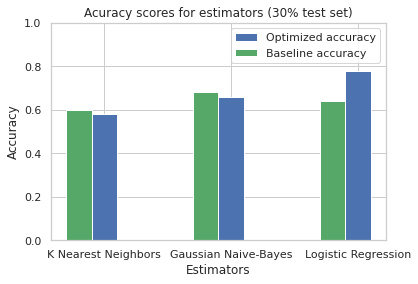

In [107]:
xax = np.arange(len(optimized_acc))
ax = plt.subplot(111)
ax.bar(xax, optimized_acc.values(), width=0.2, color='b', align='center')
ax.bar(xax-0.2, baseline_acc.values(), width=0.2, color='g', align='center')
ax.legend(('Optimized accuracy','Baseline accuracy'))
plt.xticks(xax, optimized_acc.keys())
plt.ylabel("Accuracy")
plt.xlabel("Estimators")
plt.title("Acuracy scores for estimators (30% test set)")
ax.set_ylim([0, 1])
plt.show()

Από τη γραφική παράσταση φαίνεται πως ο μόνος ταξινομητής του οποίο η επίδοση βελτιώνεται είναι ο LR, του οποίου το accuracy βελτιώνεται περίπου κατά 0.15, ενώ οι άλλοι δύο ταξινομητές δεν βελτιώνουν την επίδοσή τους στο test set. 

In [109]:
print("Αρχικές επιδόσεις:", baseline_acc)
print("Επιδόσεις βελτιστοποιημένων ταξινομητών:", optimized_acc)
print("kNN train time {:.2f} ms".format(train_time_knn*1000))
print("kNN test time {:.2f} ms".format(test_time_knn*1000))
print("GNB train time {:.2f} ms".format(train_time_gnb*1000))
print("GNB test time {:.2f} ms".format(test_time_gnb*1000))
print("LR train time {:.2f} ms".format(train_time_lr*1000))
print("LR test time {:.2f} ms".format(test_time_lr*1000))

Αρχικές επιδόσεις: {'K Nearest Neighbors': 0.6, 'Gaussian Naive-Bayes': 0.68, 'Logistic Regression': 0.64}
Επιδόσεις βελτιστοποιημένων ταξινομητών: {'K Nearest Neighbors': 0.58, 'Gaussian Naive-Bayes': 0.66, 'Logistic Regression': 0.78}
kNN train time 15.95 ms
kNN test time 6.36 ms
GNB train time 11.72 ms
GNB test time 3.57 ms
LR train time 11.25 ms
LR test time 3.47 ms


| Classifier           | Best accuracy (training set) | Accuracy (baseline) | Accuracy (optimized) | Optimization time (sec) | Train time (ms) | Test time (ms) |
|----------------------|------------------------------|---------------------|----------------------|-------------------------|-----------------|----------------|
| K Nearest Neighbors  | 72.2%                        | 60%                 | 58%                  | 29.00                   | 15.95           | 6.36           |
| Gaussian Naive-Bayes | 73.8%                        | 68%                 | 66%                  | 16.74                   | 11.72           | 3.57           |
| Logistic Regression  | 70.5%                        | 64%                 | 78%                  | 292.20                  | 11.25           | 3.47           |

Όπως και πριν ο χρόνος που απαιτεί ο LR στο στάδιο optimization είναι αρκετά μεγαλύτερος των άλλων δύο ταξινομητών. Ωστόσο στο συγκεκριμένο dataset το train time και το test time έχουν πολύ κοντινές τιμές για όλους τους ταξινομητές. Η βελτίωση στο accuracy του LR δικαιολογεί το χρόνο που σπαταλήσαμε στο optimization, αφού η επίδοσή του πηγαίνει από το 64% στο 78%, ενώ η δεύτερη καλύτερη επίδοση είναι του GNB στην baseline έκδοσή του με 68%. Επομένως, με βάση τη μετρική accuracy ο LR είναι ξεκάθαρος νικητής.

Παρακάτω δίνονται τα confusion matrices για τον καλύτερο (LR) και τον χειρότερο (kNN) ταξινομητή ως προς την ορθότητα.

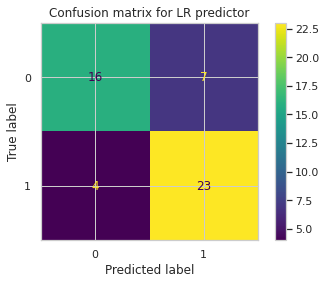

In [117]:
cm = confusion_matrix(y_test, lr_best_accuracy.predict(X_test), labels=lr_best_accuracy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_best_accuracy.classes_)
disp.plot()
plt.title("Confusion matrix for LR predictor")
plt.show()

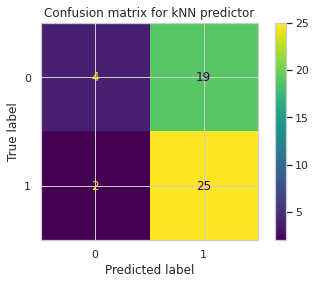

In [118]:
cm = confusion_matrix(y_test, knn_best_accuracy.predict(X_test), labels=knn_best_accuracy.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_best_accuracy.classes_)
disp.plot()
plt.title("Confusion matrix for kNN predictor")
plt.show()

Βλέπουμε πως ενώ ο LR κάνει missclassify 7 δείγματα από τη μία κατηγορία και 4 από την άλλη, ο kNN ουσιαστικά προβλέπει για όλα τα δείγματα την τιμή 1. Ο Logistic Regression ταξινομητής φαίνεται να δουλεύει καλύτερα στο πρόβλημα αυτό, καθώς τα χαρακτηριστικά των δεδομένων δεν ακολουθούν κανονική κατανομή με βάση την κλάση τους, ούτε βρίσκονται σχετικά συγκεντρωμένα στον πολυδιάστατο χώρο που βρίσκονται αλλά είναι διαχωρίσιμα. Έτσι, τα μοντέλα Gaussian Naive-Bayes και K Nearest Neighbors αντίστοιχα δεν επιτυγχάνουν υψηλές επιδόσεις ενώ το μοντέλο LR καταφέρνει να πετύχει υψηλά ποσοστά επιτυχίας.